In [1]:
import h5py
import sys
import matplotlib.pyplot as plt
import numpy as np
import fenics as fe

sys.path.insert(0, "../scripts/")

from mpi4py import MPI
from swe_2d import ShallowTwo

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
mesh_file = "../mesh/swe-square-cylinder-test.xdmf"
output_file = "../outputs/swe-lyn-rodi-coarse-testing.h5"

# outputs = h5py.File(output_file, mode="r")
outputs = fe.HDF5File(MPI.COMM_WORLD, output_file, "r")

In [3]:
simulation = "cylinder"
control = {"dt": 1e-3,
           "theta": 0.6,
           "simulation": simulation,
           "laplacian": True,
           "les": False,
           "integrate_continuity_by_parts": True}

swe = ShallowTwo(mesh=mesh_file, control=control)
outputs.read(swe.du, "/du/vector_99")
outputs.close()

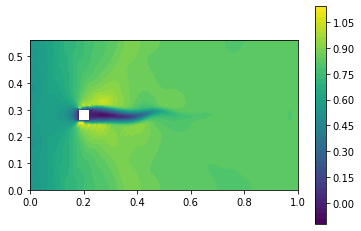

In [7]:
u, h = swe.du.split()
im = fe.plot(u.sub(0))
plt.colorbar(im)
plt.show()

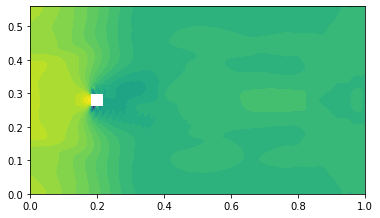

In [5]:
fe.plot(h)
plt.show()

In [15]:
u([0.24, 0.28])

array([-0.04298011,  0.02595628])